In [20]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
from itertools import islice 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import sys
sys.path.insert(0, "/data/u934/service_imagerie/v_kapoor/anaconda2/bin/PyImage/utils")
from tifffile import imread
from csbdeep.utils import Path, normalize
from skimage.segmentation import find_boundaries
from csbdeep.io import save_tiff_imagej_compatible
from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap, draw_polygons, sample_points,fill_label_holes
from stardist import Config, StarDist
import skimage
import scipy
from Normalize import Path,normalizeMinMax, fill_label_holes, save_tiff_imagej_compatible
from skimage import measure
from skimage import filters
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu
from skimage.exposure import rescale_intensity
from scipy import ndimage
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [2]:
basedir = '/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/test3D/'
basedirResultsWithoutShape = '/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/results3D/'
ModelNameWithoutShape = 'StemCellWithoutShapeCompletion'
BaseDirModels = 'models'

In [3]:
Path = os.path.join(basedir, '*.tif')
X = []
Y = []
Names = []

filesRaw = glob.glob(Path)
maxtime = 0
for fname in filesRaw:
     x = imread(fname)
     X.append(x)
     Names.append(fname)
     if X[0].shape[0] > maxtime:
      maxtime =  X[0].shape[0]  
X.sort
Names.sort



for i in range(len(X)):
    y = np.zeros((maxtime, X[0].shape[1], X[0].shape[2]))
    image = X[i]
    
    y[:X[i].shape[0],:,:] = image[:,:,:]
    Y.append(y) 
Y.sort
axes = 'TYX'
thresh = 0.5
print('Total number of images to be segmented = ', len(X))
print('Image size = ', X[0].shape)
print('Time dim = ', maxtime )
timerange = maxtime 
count = min(0, len(X))

Total number of images to be segmented =  1
Image size =  (73, 512, 512)
Time dim =  73


In [4]:
model_no_sc = StarDist(None, name = ModelNameWithoutShape, basedir = BaseDirModels )

Loading network weights from 'weights_best.h5'.


In [21]:
img = normalize(Y[0],1,99.8)
prob = np.array(img)
labels = np.array(img)


dist = np.zeros((img.shape[0], img.shape[1] ,img.shape[2], 32))
coord = np.zeros((img.shape[0], img.shape[1] ,img.shape[2],2, 32))


maxpoints = 0;
secdim = 0;
for i in range(timerange):
      smallimg = img[i,:,:]
      smallprob, smalldist = model_no_sc.predict(smallimg)
      smallcoord = dist_to_coord(smalldist)
      smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=thresh)
      secdim = smallpoints.shape[1]
      if smallpoints.shape[0] > maxpoints: 
          maxpoints = smallpoints.shape[0]
            
            
points = np.zeros((img.shape[0],maxpoints ,2), dtype = 'i')           
newsmallpoints = np.zeros((maxpoints, secdim), dtype = 'i')
for i in range(timerange):
   
   smallimg = img[i,:,:]
   smallprob, smalldist = model_no_sc.predict(smallimg)
   smallcoord = dist_to_coord(smalldist)
   smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=thresh)
   
   newsmallpoints[:smallpoints.shape[0], :smallpoints.shape[1]] = smallpoints;
   
   smallabels = polygons_to_label(smallcoord,smallprob,newsmallpoints)
   
   binary  =  smallprob > 0
      
   Consmalllabels, nr_objects = ndimage.label(binary > 0) 
   nonormimg = fill_label_holes(Consmalllabels[:,:] )
   nonormimg = remove_small_objects(nonormimg, min_size=64, connectivity=4, in_place=False)
   min = np.amin(nonormimg)
   max = np.amax(nonormimg)
   nonormimg = normalizeMinMax(nonormimg, min, max) 
    
   labels[i,:,:] = nonormimg[:,:] 
   prob[i,:,:] = smallprob[:,:] 
   
   dist[i,:,:,:] = smalldist[:,:,:]
   coord[i,:,:,:,:] = smallcoord[:,:,:,:]
    
            
    
   points[i,:,:] = newsmallpoints[:,:] 
  
 

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/skimage/morphology/misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/data/u934/service_imagerie/v_kapoor/anaconda2/bin/PyImage/utils/Normalize.py:89: RuntimeWarning: invalid value encountered in true_divide
  x = mi + ((x - min ) / (max - min)) * ma


Time point =  72


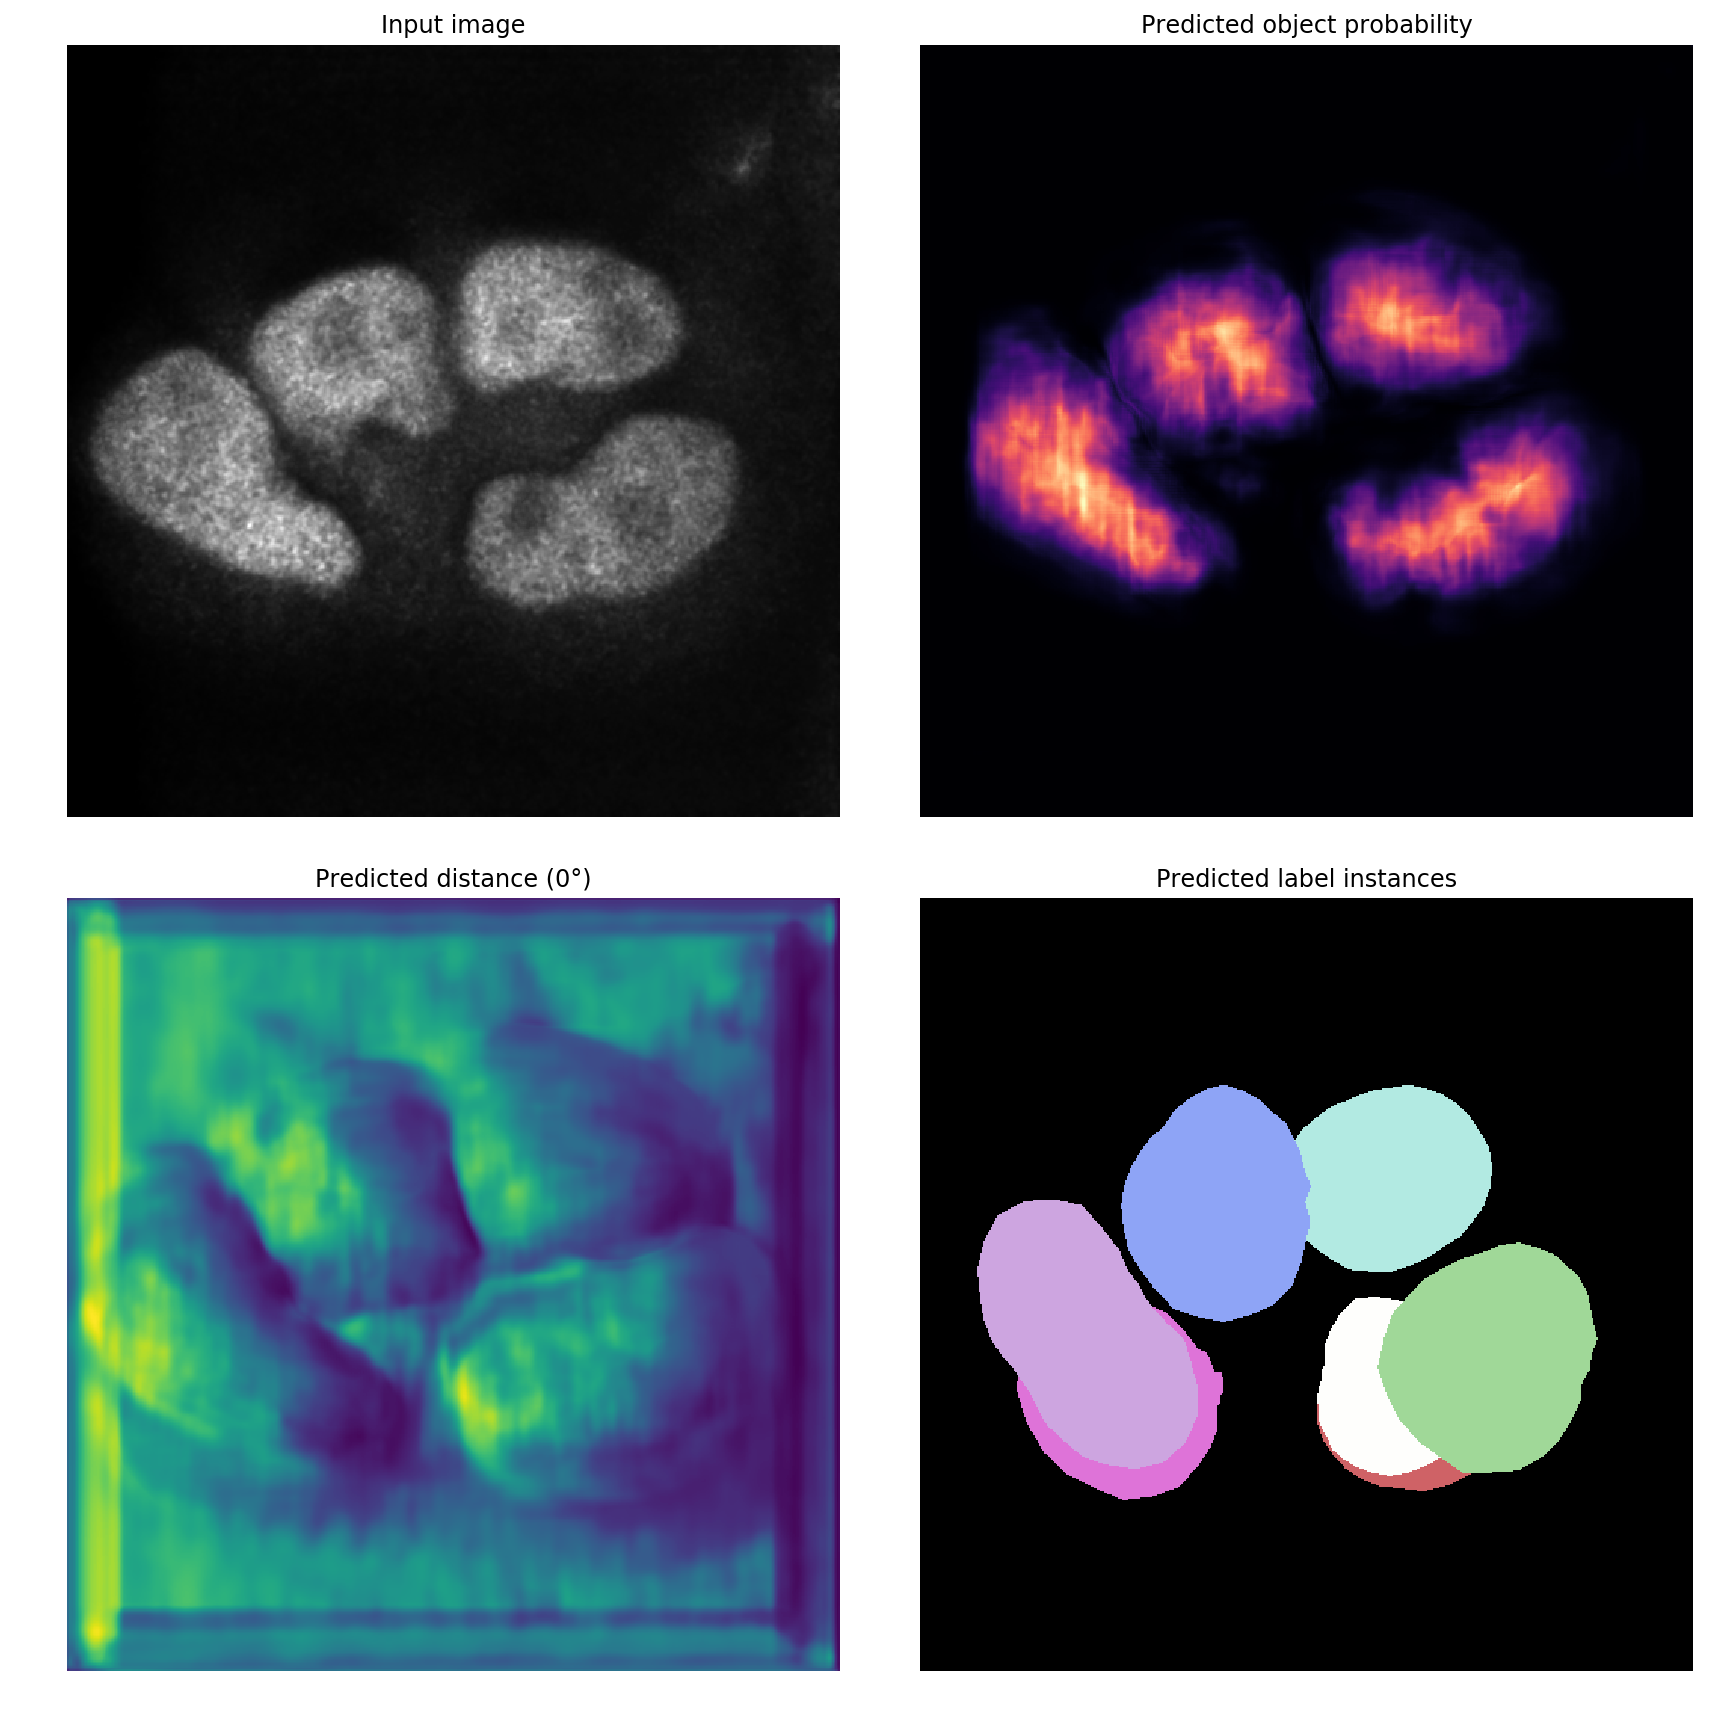

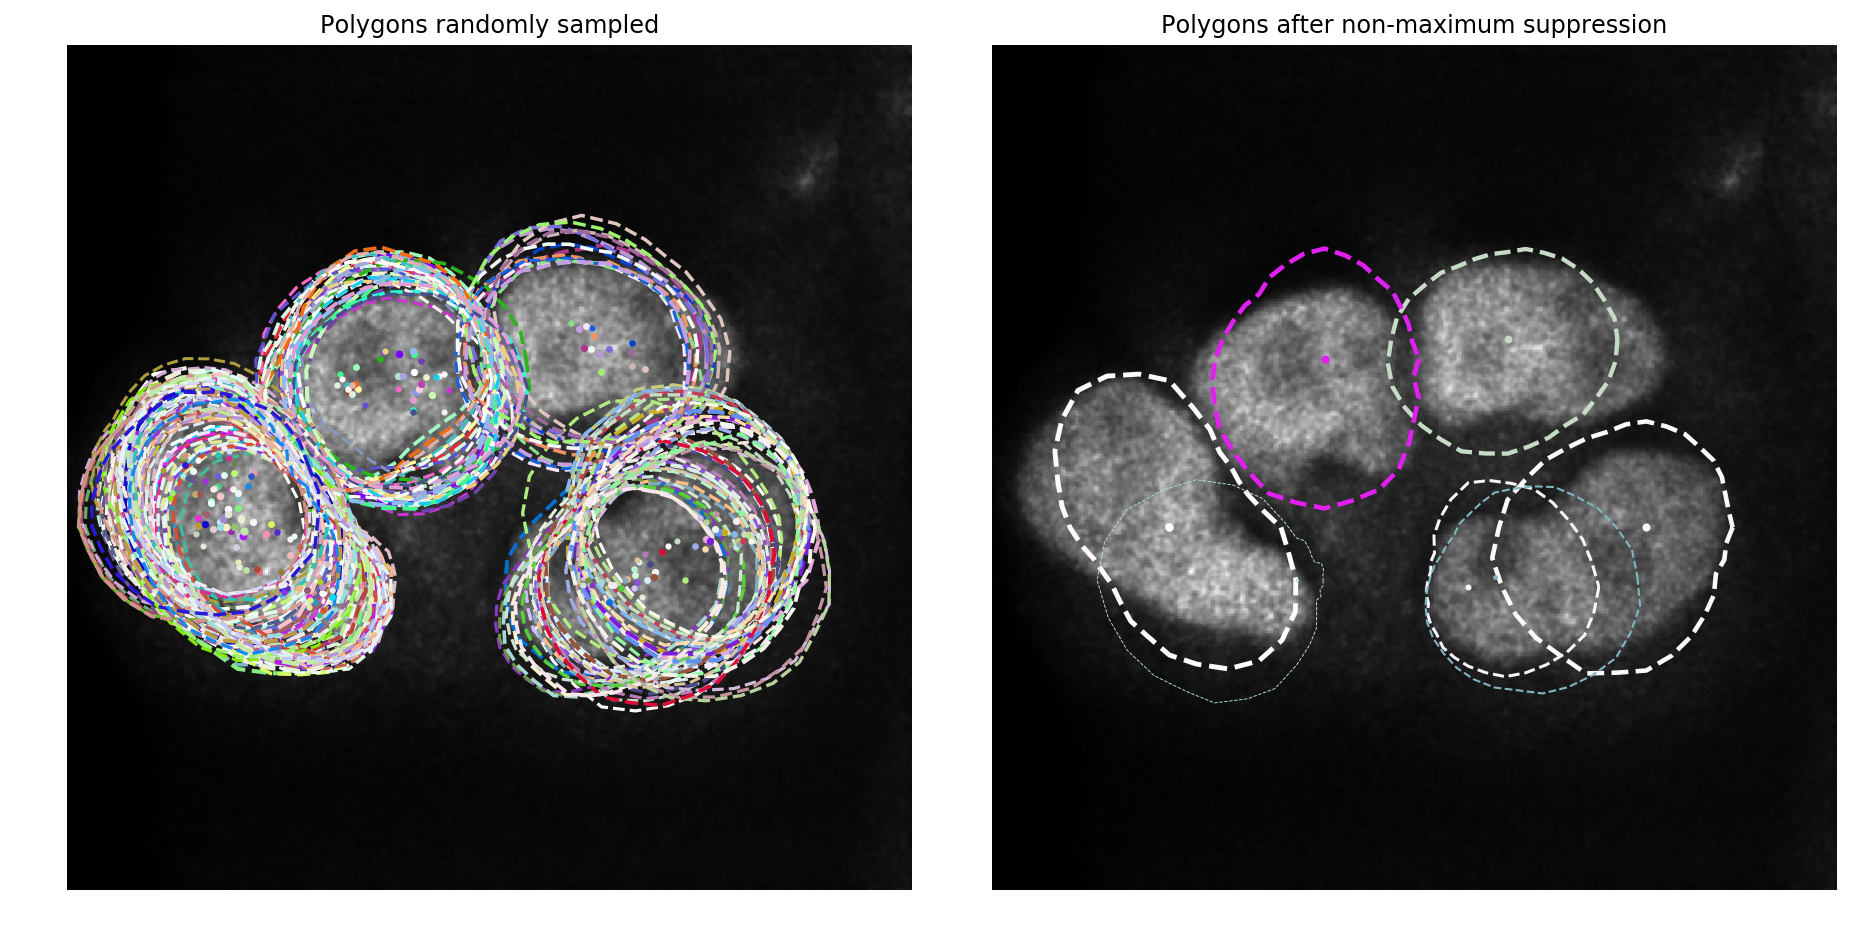

In [22]:
newsmallabels = np.array(smallabels)
newsmallprob = np.array(smallprob)
newsmalldist = np.array(smalldist)
newsmallimg = np.array(smallimg)
newsmallcoord = np.array(smallcoord)
i = timerange - 1
print('Time point = ' , i)
newsmalldist  = dist[i,:,:,:]
newsmalllabels = labels[i,:,:] 
newsmallprob = prob[i,:,:] 
newsmallimg = img[i,:,:]
newsmallcoord = coord[i,:,:,:,:]
fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [newsmallimg,newsmallprob,newsmalldist[...,0],newsmallabels], ['gray','magma','viridis',lbl_cmap],
                    ['Input image','Predicted object probability','Predicted distance (0°)','Predicted label instances']):
          a.imshow(d,cmap=cm)
          a.set_title(s)
          a.axis('off')
          plt.tight_layout()
None;


plt.figure(figsize=(13,12))
points_rnd = sample_points(200,newsmallprob>thresh)
numberA = 121
numberB = 122 
plt.subplot(numberA); plt.imshow(newsmallimg,cmap='gray'); 
draw_polygons(newsmallcoord,newsmallprob,points_rnd,cmap=lbl_cmap)
plt.axis('off'); plt.title('Polygons randomly sampled')
      
plt.subplot(numberB); plt.imshow(newsmallimg,cmap='gray'); draw_polygons(newsmallcoord,newsmallprob,newsmallpoints,cmap=lbl_cmap)
plt.axis('off'); plt.title('Polygons after non-maximum suppression')
plt.tight_layout()

In [35]:
 def ApplyAll(model, img):
    for j in range(timerange):
      smallimg = img[j,:,:]
      smallprob, smalldist = model_no_sc.predict(smallimg)
      smallcoord = dist_to_coord(smalldist)
      smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=thresh)
   
      smalllabels = polygons_to_label(smallcoord,smallprob,smallpoints)
      binary  =  smallprob > 0
      
      Consmalllabels, nr_objects = ndimage.label(binary > 0) 
      nonormimg = fill_label_holes(smalllabels[:,:] )
      nonormimg = remove_small_objects(nonormimg, min_size=64, connectivity=4, in_place=False)
      min = np.amin(nonormimg)
      max = np.amax(nonormimg)
      nonormimg = normalizeMinMax(nonormimg, min, max) 
      prob[j,:,:] = smallprob[:,:] 
      labels[j,:,:] = nonormimg[:,:]
      dist[j,:,:,:] = smalldist[:,:,:]
      coord[j,:,:,:,:] = smallcoord[:,:,:,:]

        
    return labels
    
    
        
        
      
  

In [36]:

for i in range(0, len(Y)):

 img = normalize(Y[i],1,99.8)
 ApplyAll(model_no_sc,img)   

        
 

 save_tiff_imagej_compatible((basedirResultsWithoutShape +'Star'+ os.path.basename(Names[i])) , labels, axes)   


/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/utils/utils.py:209: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[slices]
